In [61]:
import osmnx as ox
import networkx as nx
import folium
from folium.plugins import Draw
import gpxpy.gpx
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import geopandas as gpd

# Get the map as graph

In [62]:
place = "Wilrijk, Antwerp, Belgium"
# G = ox.graph_from_place(place, network_type='all')
street = f"Elsdonklaan, {place}"

# Note: using network_type all, since some important large roads are not included with 'walk'
G = ox.graph_from_address(street, dist=3000, network_type='all')

Exploring paths: 1paths [27:56, 1676.90s/paths, 0.0 m]
Exploring paths: 316074paths [13:56, 377.64paths/s, 12621.1 m] 
Exploring paths: 1paths [03:53, 233.16s/paths, 0.0 m]
Exploring paths: 5045paths [03:46, 22.24paths/s, 9239.2 m] 


In [63]:
G = ox.distance.add_edge_lengths(G)

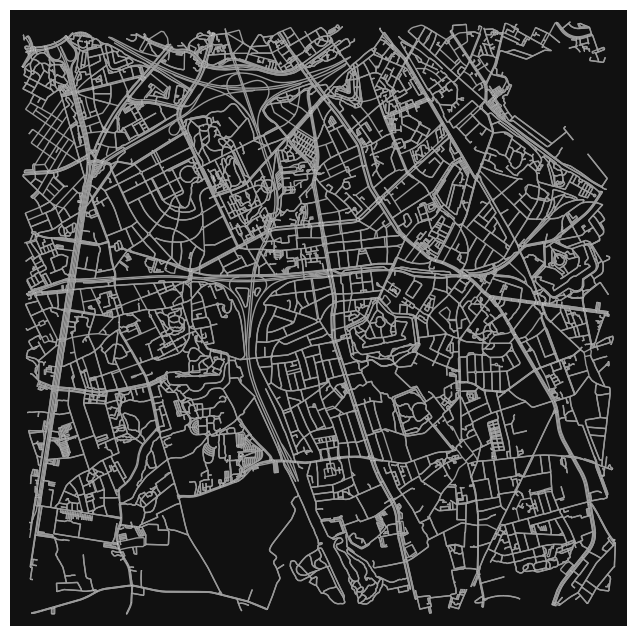

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [64]:
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected, node_size=0.1)

# Starting point and bounding area

## Interactive map

In [65]:
def create_interactive_map(G):
    """
    Creates an interactive map with nodes and edges from the graph G.
    Saves the map as an HTML file for visualization and selection.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        folium.Map: The generated interactive map.
    """
    # Convert to GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

    # Get map center
    center_node = ox.nearest_nodes(G, X=edges.unary_union.centroid.x, Y=edges.unary_union.centroid.y)
    center_lat = G.nodes[center_node]['y']
    center_lon = G.nodes[center_node]['x']

    # Create Folium map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=15, control_scale=True)

    # Add edges with tooltip info
    for idx, row in edges.iterrows():
        u, v, k = idx
        coords = [(point[1], point[0]) for point in row['geometry'].coords]
        tooltip = f"Edge {u}-{v}, name: {row.get('name', 'unknown')}"
        folium.PolyLine(coords, color='gray', weight=2, tooltip=tooltip).add_to(m)

    # Add nodes as clickable markers (for selection)
    for node_id, data in G.nodes(data=True):
        folium.CircleMarker(
            location=(data['y'], data['x']),
            radius=2,
            color='blue',
            fill=True,
            tooltip=f"Node {node_id}"
        ).add_to(m)

    # Add drawing tools
    folium.plugins.Draw(export=True).add_to(m)

    # Save the map to an HTML file
    m.save("select_node_and_boundary.html")
    return m

# Create and save the interactive map
interactive_map = create_interactive_map(G)

C:\Users\arnod\AppData\Local\Temp\ipykernel_22416\2634528514.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center_node = ox.nearest_nodes(G, X=edges.unary_union.centroid.x, Y=edges.unary_union.centroid.y)


Open the generated html file. Find the node id of your starting point. Draw a polyglon of your bounding area. 

## Start node

In [66]:
start_node = 94282708

## Bounding area

### Based on street names

In [67]:
# # Replace with streets that form the boundary
# boundary_street_names = ["Elsdonklaan", "Jozef Reusenslei", "Doornstraat"]
# # Filter edges based on boundary names
# boundary_edges = edges[edges['name'].isin(boundary_street_names)]
# # Create boundary polygon (approximate convex hull of boundary lines)
# boundary_polygon = boundary_edges.unary_union.convex_hull

### Based on exported polygon

In [68]:
import json
from shapely.geometry import shape

filename = "data.geojson"
filename = "data_elsdonklaan_test.geojson"
# filename = "data_elsdonklaan_wijk_detail.geojson"
with open(filename) as f:
    data = json.load(f)

polygon_coords = data['features'][0]['geometry']
boundary_polygon = shape(polygon_coords)

In [69]:
# Filter nodes inside polygon
nodes_inside = [n for n, d in G.nodes(data=True)
                if boundary_polygon.contains(Point(d['x'], d['y']))]
G_sub = G.subgraph(nodes_inside).copy()

## Visualize set parameters

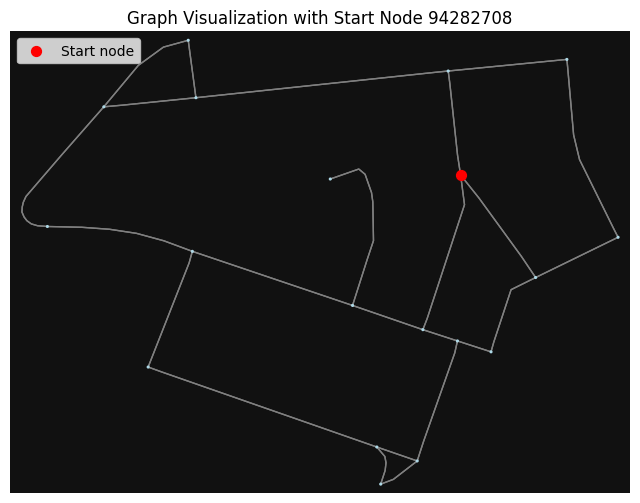

In [70]:
def visualize_graph(graph, start_node=None):
    """
    Visualizes the graph with nodes and edges. Optionally highlights a start node.

    Parameters:
        graph (networkx.Graph): The graph to visualize.
        start_node (int, optional): The node ID to highlight as the start node.

    Returns:
        None: Displays the plot.
    """
    import matplotlib.pyplot as plt
    import osmnx as ox

    fig, ax = ox.plot_graph(
        graph,
        node_size=5,
        node_color="lightblue",
        edge_color="gray",
        show=False,
        close=False,
    )

    if start_node is not None:
        # Plot start node in red
        x, y = graph.nodes[start_node]['x'], graph.nodes[start_node]['y']
        ax.scatter(x, y, c='red', s=50, label='Start node', zorder=5)
        ax.legend()

    plt.title("Graph Visualization" + (f" with Start Node {start_node}" if start_node else ""))
    plt.show()

visualize_graph(G_sub, start_node=start_node)


## Simplify graph

Cluster close to each other nodes as one (since some intersections consists of multiple nodes)

In [71]:
import networkx as nx
import numpy as np
from sklearn.cluster import DBSCAN
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point

# Projected graph for clustering
G_proj = ox.project_graph(G_sub)
coords_proj = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in G_proj.nodes()])

# Cluster nodes within 20 meters
clustering = DBSCAN(eps=20, min_samples=1, metric='euclidean').fit(coords_proj)

labels = clustering.labels_
node_to_cluster = {node: cluster for node, cluster in zip(G_proj.nodes(), labels)}

# Create a GeoDataFrame of cluster centroids in projected CRS
cluster_points = []
cluster_ids = []

for cluster_id in set(labels):
    cluster_nodes = [n for n in G_proj.nodes() if node_to_cluster[n] == cluster_id]
    x_mean = np.mean([G_proj.nodes[n]['x'] for n in cluster_nodes])
    y_mean = np.mean([G_proj.nodes[n]['y'] for n in cluster_nodes])
    point = Point(x_mean, y_mean)
    cluster_points.append(point)
    cluster_ids.append(cluster_id)

gdf_centroids = gpd.GeoDataFrame({'cluster_id': cluster_ids}, geometry=cluster_points, crs=G_proj.graph['crs'])

# Reproject centroids back to WGS84 (lat/lon)
gdf_centroids = gdf_centroids.to_crs(epsg=4326)

# Build new graph H in WGS84
H = nx.MultiDiGraph()
H.graph.update(G_sub.graph)  # Copy original lat/lon CRS (not projected!)

# Add merged nodes with proper lat/lon coordinates
for i, row in gdf_centroids.iterrows():
    lat = row.geometry.y
    lon = row.geometry.x
    cluster_id = row['cluster_id']
    cluster_nodes = [n for n, cid in node_to_cluster.items() if cid == cluster_id]
    H.add_node(cluster_id, x=lon, y=lat, orig_nodes=cluster_nodes)

# Add edges between cluster nodes
for u, v, data in G_proj.edges(data=True):
    cu = node_to_cluster[u]
    cv = node_to_cluster[v]
    if cu != cv:
        length = data.get('length', 0)
        H.add_edge(cu, cv, length=length)
        H.add_edge(cv, cu, length=length)


## Regenarate interactive map
Since the start node might have been changed

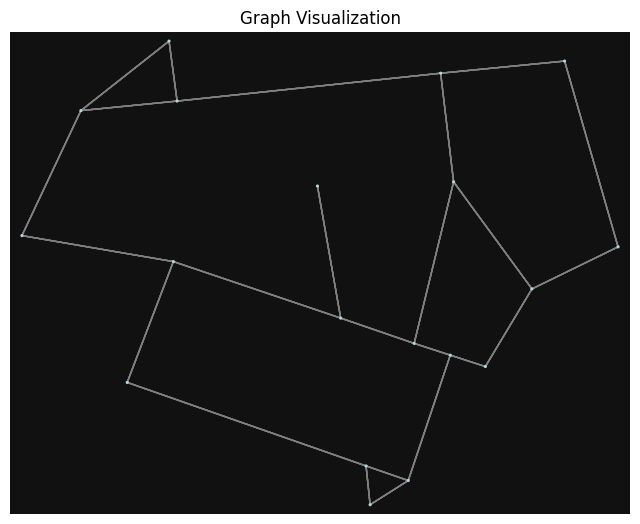

In [72]:
visualize_graph(H)

In [73]:
_ = create_interactive_map(H)

C:\Users\arnod\AppData\Local\Temp\ipykernel_22416\2634528514.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center_node = ox.nearest_nodes(G, X=edges.unary_union.centroid.x, Y=edges.unary_union.centroid.y)


Now re-assign the id of the start node

In [77]:
start_node = 11

# DFS
The actual path finding magic.

In [78]:
from collections import deque
import time
from tqdm import tqdm

def is_reachable_to_start(G, current_node, visited_nodes, visited_edges, start_node):
    """
    Pruning mechanism (since it takes too long without one). 
    Returns True if there is a path from current_node back to start_node avoiding visited nodes and edges.
    """
    queue = deque([current_node])
    visited = set()

    while queue:
        node = queue.popleft()
        if node == start_node:
            return True
        if node in visited:
            continue
        visited.add(node)

        for neighbor in G.neighbors(node):
            if neighbor in visited_nodes:
                continue
            edge_key_1 = (node, neighbor)
            edge_key_2 = (neighbor, node)
            if edge_key_1 in visited_edges or edge_key_2 in visited_edges:
                continue
            queue.append(neighbor)

    return False

def find_longest_cycle_by_distance(G, start_node):
    longest_path = []
    longest_distance = 0.0
    counter = [0]  # Mutable for progress
    start_time = time.time()

    progress_bar = tqdm(desc="Exploring paths", unit="paths", dynamic_ncols=True)

    def dfs(current_node, path, visited_edges, visited_nodes, current_distance):
        nonlocal longest_path, longest_distance
        progress_bar.update(1)
        progress_bar.set_postfix_str(f"{longest_distance:.1f} m")

        for neighbor in G.neighbors(current_node):
            if neighbor in visited_nodes:
                continue

            # Get edge data (use min if multigraph)
            edge_data = G.get_edge_data(current_node, neighbor)
            if edge_data is None:
                continue

            # Since this is a MultiGraph, pick the shortest/first edge (or do something smarter later)
            edge_key = (current_node, neighbor)
            if edge_key in visited_edges or (neighbor, current_node) in visited_edges:
                continue

            edge_info = edge_data[next(iter(edge_data))]
            edge_length = edge_info['length']

            # Mark visited
            visited_edges.add(edge_key)
            visited_nodes.add(neighbor)
            path.append(neighbor)
            new_distance = current_distance + edge_length

            if neighbor == start_node and len(path) > 2:
                # Found cycle
                if new_distance > longest_distance:
                    print(f"🎯 Found new longest cycle: {new_distance:.1f} meters")
                    longest_path = list(path)
                    longest_distance = new_distance
            elif is_reachable_to_start(G, neighbor, visited_nodes, visited_edges, start_node):
                dfs(neighbor, path, visited_edges, visited_nodes, new_distance)

            # Backtrack
            path.pop()
            visited_edges.remove(edge_key)
            visited_nodes.remove(neighbor)

    print("🚀 Starting DFS from node", start_node)
    dfs(start_node, [start_node], set(), set(), 0.0)

    elapsed = time.time() - start_time
    print(f"✅ Done. Longest cycle: {longest_distance:.1f} meters in {elapsed:.2f}s.")
    return longest_path, longest_distance


## Running the code

In [79]:
longest_cycle, total_length = find_longest_cycle_by_distance(H, start_node)

🚀 Starting DFS from node 11
🎯 Found new longest cycle: 918.3 meters
🎯 Found new longest cycle: 1207.5 meters
🎯 Found new longest cycle: 1236.8 meters
🎯 Found new longest cycle: 1256.6 meters
🎯 Found new longest cycle: 1454.2 meters
🎯 Found new longest cycle: 1510.6 meters
🎯 Found new longest cycle: 1539.9 meters


Exploring paths: 105paths [00:00, 553.92paths/s, 1539.9 m]

✅ Done. Longest cycle: 1539.9 meters in 0.37s.


## Visualize longest cycle

In [80]:
import matplotlib.pyplot as plt
import osmnx as ox

def plot_path(G, path, total_length):
    fig, ax = ox.plot_graph(G, show=False, close=False, node_size=5, node_color="gray", edge_color="lightgray")
    x = [G.nodes[n]['x'] for n in path]
    y = [G.nodes[n]['y'] for n in path]
    
    ax.plot(x, y, color='red', linewidth=3, zorder=5, label="Longest Cycle")
    ax.scatter(x[0], y[0], color='green', s=50, zorder=6, label="Start/End")
    
    ax.legend()
    plt.title(f"Longest Cycle: {total_length:.1f} meters")
    plt.show()


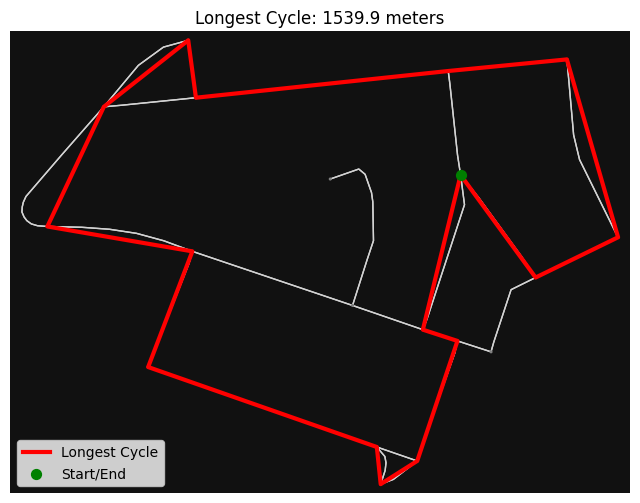

In [ ]:
plot_path(H, longest_cycle, total_length)

## Save it as gpx

In [81]:
import gpxpy
import gpxpy.gpx
from shapely.geometry import LineString

def export_path_to_gpx_with_edges(G, path, filename="longest_cycle.gpx"):
    gpx = gpxpy.gpx.GPX()
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx.tracks.append(gpx_track)
    gpx_segment = gpxpy.gpx.GPXTrackSegment()
    gpx_track.segments.append(gpx_segment)

    for u, v in zip(path[:-1], path[1:]):
        edge_data = G.get_edge_data(u, v)
        if edge_data is None:
            edge_data = G.get_edge_data(v, u)  # fallback to undirected
            if edge_data is None:
                raise ValueError(f"No edge between {u} and {v}")

        # Pick the first edge variant (there may be multiple parallel edges)
        edge = edge_data[next(iter(edge_data))]

        if 'geometry' in edge:
            # Use the LineString geometry
            coords = list(edge['geometry'].coords)
        else:
            # Just straight from u to v
            coords = [(G.nodes[u]['x'], G.nodes[u]['y']),
                      (G.nodes[v]['x'], G.nodes[v]['y'])]

        for lon, lat in coords:
            gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(latitude=lat, longitude=lon))

    with open(filename, "w") as f:
        f.write(gpx.to_xml())
    
    print(f"✅ GPX with geometry exported to {filename}")


In [82]:
export_path_to_gpx_with_edges(H, longest_cycle)

✅ GPX with geometry exported to longest_cycle.gpx
